# Natural Language Processing - Text Classification
The goal of this assignment is to try number of Machine Learning algorithms in text classification. <br>
The generated model should be able to predict the class (category) of an unseen document correctly out of 91 classes

In [1]:
# Importing needed libraries
import os
import pandas as pd

# Cleaning and Normalization
import re
import numpy as np
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# EDA
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

# Features Engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling and Evaluating
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_fscore_support
import pickle 

## 1. Reading data
In this step I'll read each file in each folder, and append the [folder name, file contents] to one pandas dataframe. 

In [2]:
def read_folders_to_dataframe(parent_dir: str) -> pd.DataFrame:
    """
    Reads the contents of all text files in all subdirectories of a given directory and returns the results as a Pandas DataFrame.

    Args:
        parent_dir (str): The path of the parent directory containing the subdirectories to read.

    Returns:
        A Pandas DataFrame containing the file contents with columns for folder name and file contents.
    """
    data = []
    # loop through each folder in the parent directory and its subdirectories
    for root, _, files in os.walk(parent_dir):
        for file_name in files:
            # check if the file is a text file
            if file_name.endswith('.txt'):
                file_path = os.path.join(root, file_name)
                with open(file_path, 'r') as f:
                    file_contents = f.read()
                # append the folder name and file contents to the list
                data.append([os.path.basename(root), file_contents])
    # create a DataFrame from the list
    df = pd.DataFrame(data, columns=['folder_name', 'file_contents'])
    return df


In [3]:
data = read_folders_to_dataframe("../data")
data.head()

,folder_name,file_contents
0,acq,\n\nCOMPUTER TERMINAL SYSTEMS <CPML> COMPLETES...
1,acq,\n\nOHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR...
2,acq,\n\nMCLEAN'S <MII> U.S. LINES SETS ASSET TRANS...
3,acq,\n\nCHEMLAWN <CHEM> RISES ON HOPES FOR HIGHER ...
4,acq,\n\n<COFAB INC> BUYS GULFEX FOR UNDISCLOSED AM...


## Text Preprocessing
The purpose of text preprocessing is to <b>clean</b> and <b>normalize</b> the text data so that it can be more easily analyzed and modeled by machine learning algorithms which also helps improving the accuracy of the models.

## 2. Cleaning Text
In this step I'll remove any irrelevant or unnecessary elements from the text data to make it more suitable for analysis. <br>
The cleaning process involves: <br>
- stop words removal: using stopwords from nltk.corpus  
- html tags removal: using BeautifulSoap html parser
- special chars removal: using regex.
- punctuations removal: using regex. 

In [4]:
def remove_punctuations(text):
    """
    Removes all punctuation marks from a given text.

    Args:
        text (str): The text to remove punctuation from.

    Returns:
        The text with all punctuation marks removed.
    """
    return re.sub(r'[^\w\s]', '', text)

def remove_stopwords(text):
    """
    Removes all stopwords from a given text.

    Args:
        text (str): The text to remove stopwords from.

    Returns:
        The text with all stopwords removed.
    """
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return " ".join(filtered_tokens)

def remove_special_chars(text):
    """
    Removes all non-ASCII characters from a given text.

    Args:
        text (str): The text to remove special characters from.

    Returns:
        The text with all non-ASCII characters removed.
    """
    return re.sub(r'[^\x00-\x7f]', r'', text)

def remove_tags(text):
    """
    Removes all HTML tags and newlines from a given text.

    Args:
        text (str): The text to remove tags from.

    Returns:
        The text with all HTML tags and newlines removed.
    """
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text().replace("\n", " ").strip()
    return clean_text

def clean_text(text):
    """
    Cleans a given text by removing HTML tags, punctuation marks, stopwords, and non-ASCII characters.

    Args:
        text (str): The text to clean.

    Returns:
        The cleaned text.
    """
    text = remove_tags(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    text = remove_special_chars(text)
    return text


In [5]:
data["text"] = data["file_contents"].apply(clean_text)
data.head()

,folder_name,file_contents,text
0,acq,\n\nCOMPUTER TERMINAL SYSTEMS <CPML> COMPLETES...,COMPUTER TERMINAL SYSTEMS COMPLETES SALE COMMA...
1,acq,\n\nOHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR...,OHIO MATTRESS MAY HAVE LOWER 1ST QTR NET CLEVE...
2,acq,\n\nMCLEAN'S <MII> U.S. LINES SETS ASSET TRANS...,MCLEANS US LINES SETS ASSET TRANSFER CRANFORD ...
3,acq,\n\nCHEMLAWN <CHEM> RISES ON HOPES FOR HIGHER ...,CHEMLAWN RISES ON HOPES FOR HIGHER BIDS By Cal...
4,acq,\n\n<COFAB INC> BUYS GULFEX FOR UNDISCLOSED AM...,BUYS GULFEX FOR UNDISCLOSED AMOUNT HOUSTON Feb...


## 3. Normalize Text
In this step I'll transform the text data into a more normalized format that can be easily analyzed.
- Lemmatization text: using WordNetLemmatizer 
- Lower case text

In [6]:
def lemmatize_text(text):
    """ 
    Args:
    text (str): The input text to be lemmatized.
    Returns:
        str: The lemmatized text.
    """
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized_tokens)

def standardize_text(text):
    """
    Args:
    text (str): The input text to be standardized.

    Returns:
        str: The standardized text.
    """
    return text.lower()

def normalize_text(text):
    """
    Cleans a given text by removing HTML tags, punctuation marks, stopwords, and non-ASCII characters.

    Args:
        text (str): The text to clean.

    Returns:
        The cleaned text.
    """
    text = lemmatize_text(text)
    text = standardize_text(text)
    return text


In [7]:
data["text"] = data["text"].apply(normalize_text)
data.head()

,folder_name,file_contents,text
0,acq,\n\nCOMPUTER TERMINAL SYSTEMS <CPML> COMPLETES...,computer terminal systems completes sale comma...
1,acq,\n\nOHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR...,ohio mattress may have lower 1st qtr net cleve...
2,acq,\n\nMCLEAN'S <MII> U.S. LINES SETS ASSET TRANS...,mcleans us lines sets asset transfer cranford ...
3,acq,\n\nCHEMLAWN <CHEM> RISES ON HOPES FOR HIGHER ...,chemlawn rises on hopes for higher bids by cal...
4,acq,\n\n<COFAB INC> BUYS GULFEX FOR UNDISCLOSED AM...,buys gulfex for undisclosed amount houston feb...


## Text Vectorization
In text vectorization, the goal is to represent the text data numerically in a way that can be used for machine learning. In this case, I have used the TfidfVectorizer from the scikit-learn library to vectorize the preprocessed text data. This involves computing the term frequency-inverse document frequency (tf-idf) score for each word in the text, which represents how important each word is in the context of the entire corpus.
<br><br>
After vectorizing the text data, I have concatenated the resulting sparse matrix with additional features including the document length and presence of certain class names in each document. This was done using the numpy library. The features were selected based on the exploratory data analysis (EDA) performed on the dataset. The EDA involved analyzing the distribution of classes, identifying the most common words in each class, and calculating the average text length. Based on the insights gained from the EDA, the features selected were document length and the presence of class names in each document.
<br><br>
Overall, the libraries used for text vectorization in this case include scikit-learn, matplotlib.pyplot and numpy.


## 4. Extract the TD-IDF Vector for each document. 
In this step I'll perform:
- Word tokenization: using NLTK. 
- TF-IDF Matrix: using the TfidfVectorizer from sklearn.

In [8]:
# Word tokenization
data['tokens'] = data['text'].apply(lambda x: nltk.word_tokenize(x.lower()))
data.head()

,folder_name,file_contents,text,tokens
0,acq,\n\nCOMPUTER TERMINAL SYSTEMS <CPML> COMPLETES...,computer terminal systems completes sale comma...,"[computer, terminal, systems, completes, sale,..."
1,acq,\n\nOHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR...,ohio mattress may have lower 1st qtr net cleve...,"[ohio, mattress, may, have, lower, 1st, qtr, n..."
2,acq,\n\nMCLEAN'S <MII> U.S. LINES SETS ASSET TRANS...,mcleans us lines sets asset transfer cranford ...,"[mcleans, us, lines, sets, asset, transfer, cr..."
3,acq,\n\nCHEMLAWN <CHEM> RISES ON HOPES FOR HIGHER ...,chemlawn rises on hopes for higher bids by cal...,"[chemlawn, rises, on, hopes, for, higher, bids..."
4,acq,\n\n<COFAB INC> BUYS GULFEX FOR UNDISCLOSED AM...,buys gulfex for undisclosed amount houston feb...,"[buys, gulfex, for, undisclosed, amount, houst..."


In [9]:
# Define the TfidfVectorizer with desired settings
tfidf = TfidfVectorizer(stop_words='english', lowercase=True, min_df=5, max_df=0.8)

# Fit the TfidfVectorizer on the tokenized data
tfidf.fit(data['tokens'].apply(lambda x: ' '.join(x)))

# Transform the tokenized data into TF-IDF vectors
tfidf_vectors = tfidf.transform(data['tokens'].apply(lambda x: ' '.join(x)))

In [10]:
tfidf_vectors

<11413x11311 sparse matrix of type '<class 'numpy.float64'>'
	with 650593 stored elements in Compressed Sparse Row format>

## 5. Exploaraity Data Analysis - EDA. 
This step helps me decide what features to generate.
In this step I'll:
- Plot the distribution of classes: bar plot. 
- Average Text Length: bar plot.
- Most Common words in each class and its frequency: Word Cloud.
- Topic Related terms and their frequencies: bar plot 

### Plot the distribution of classes

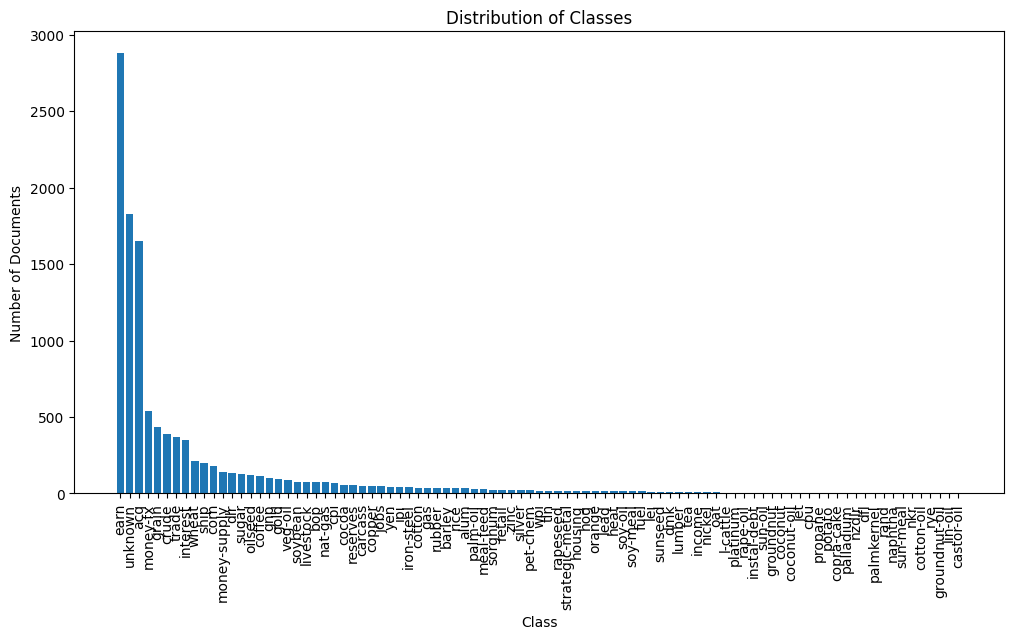

In [11]:
# Count the number of documents in each class
class_counts = data['folder_name'].value_counts()

# Plot the distribution of classes
plt.figure(figsize=(12,6))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Documents')
plt.title('Distribution of Classes')
plt.show()

From this plot we conclude that the distribution of classes is imbalanced. <br> some classes have less than 100 docs and others have more than 1000

### Average Text Length

In [12]:
def sort_dataframe_by_text_length(data):
    """
    Sorts the DataFrame based on the length of the 'text' column in descending order and adds a new column with the 
    length of the 'text' column.

    Args:
        data (pandas.DataFrame): The DataFrame to be sorted.

    Returns:
        pandas.DataFrame: The sorted DataFrame with an added 'text_length' column.
    """
    # Add a new column with the length of the 'text' column
    data['text_length'] = data['text'].str.len()

    # Sort the DataFrame based on the length of the 'text' column in descending order
    df_sorted = data.sort_values(by=['text_length'], ascending=False)

    return df_sorted


In [13]:
data = sort_dataframe_by_text_length(data)
data

,folder_name,file_contents,text,tokens,text_length
8827,tin,\n\nCOMMODITY PACTS MORE ORIENTED TOWARDS MARK...,commodity pacts more oriented towards market l...,"[commodity, pacts, more, oriented, towards, ma...",6429
8759,sugar,\n\nCOMMODITY PACTS MORE ORIENTED TOWARDS MARK...,commodity pacts more oriented towards market l...,"[commodity, pacts, more, oriented, towards, ma...",6429
8292,rubber,\n\nCOMMODITY PACTS MORE ORIENTED TOWARDS MARK...,commodity pacts more oriented towards market l...,"[commodity, pacts, more, oriented, towards, ma...",6429
1892,cocoa,\n\nCOMMODITY PACTS MORE ORIENTED TOWARDS MARK...,commodity pacts more oriented towards market l...,"[commodity, pacts, more, oriented, towards, ma...",6429
11277,wheat,\n\nCOMMODITY PACTS MORE ORIENTED TOWARDS MARK...,commodity pacts more oriented towards market l...,"[commodity, pacts, more, oriented, towards, ma...",6429
...,...,...,...,...,...
7522,money-fx,\n\nSumita says he does not repeat not expect ...,sumita say repeat expect dollar fall blah blah...,"[sumita, say, repeat, expect, dollar, fall, bl...",51
10851,unknown,"\n MARCH U.S. CAR OUTPUT 395,294, UP FROM 366,...",march us car output 395294 up from 366671 3,"[march, us, car, output, 395294, up, from, 366...",43
10845,unknown,\n TO SELL NETI TECHNOLOGIES SOFTWARE\n#3;\n\n,to sell neti technologies software 3,"[to, sell, neti, technologies, software, 3]",36
8489,ship,\n\nN.Y. SUGAR FREIGHTS - April 7\n\n Nil\n...,ny sugar freights april 7 nil,"[ny, sugar, freights, april, 7, nil]",29


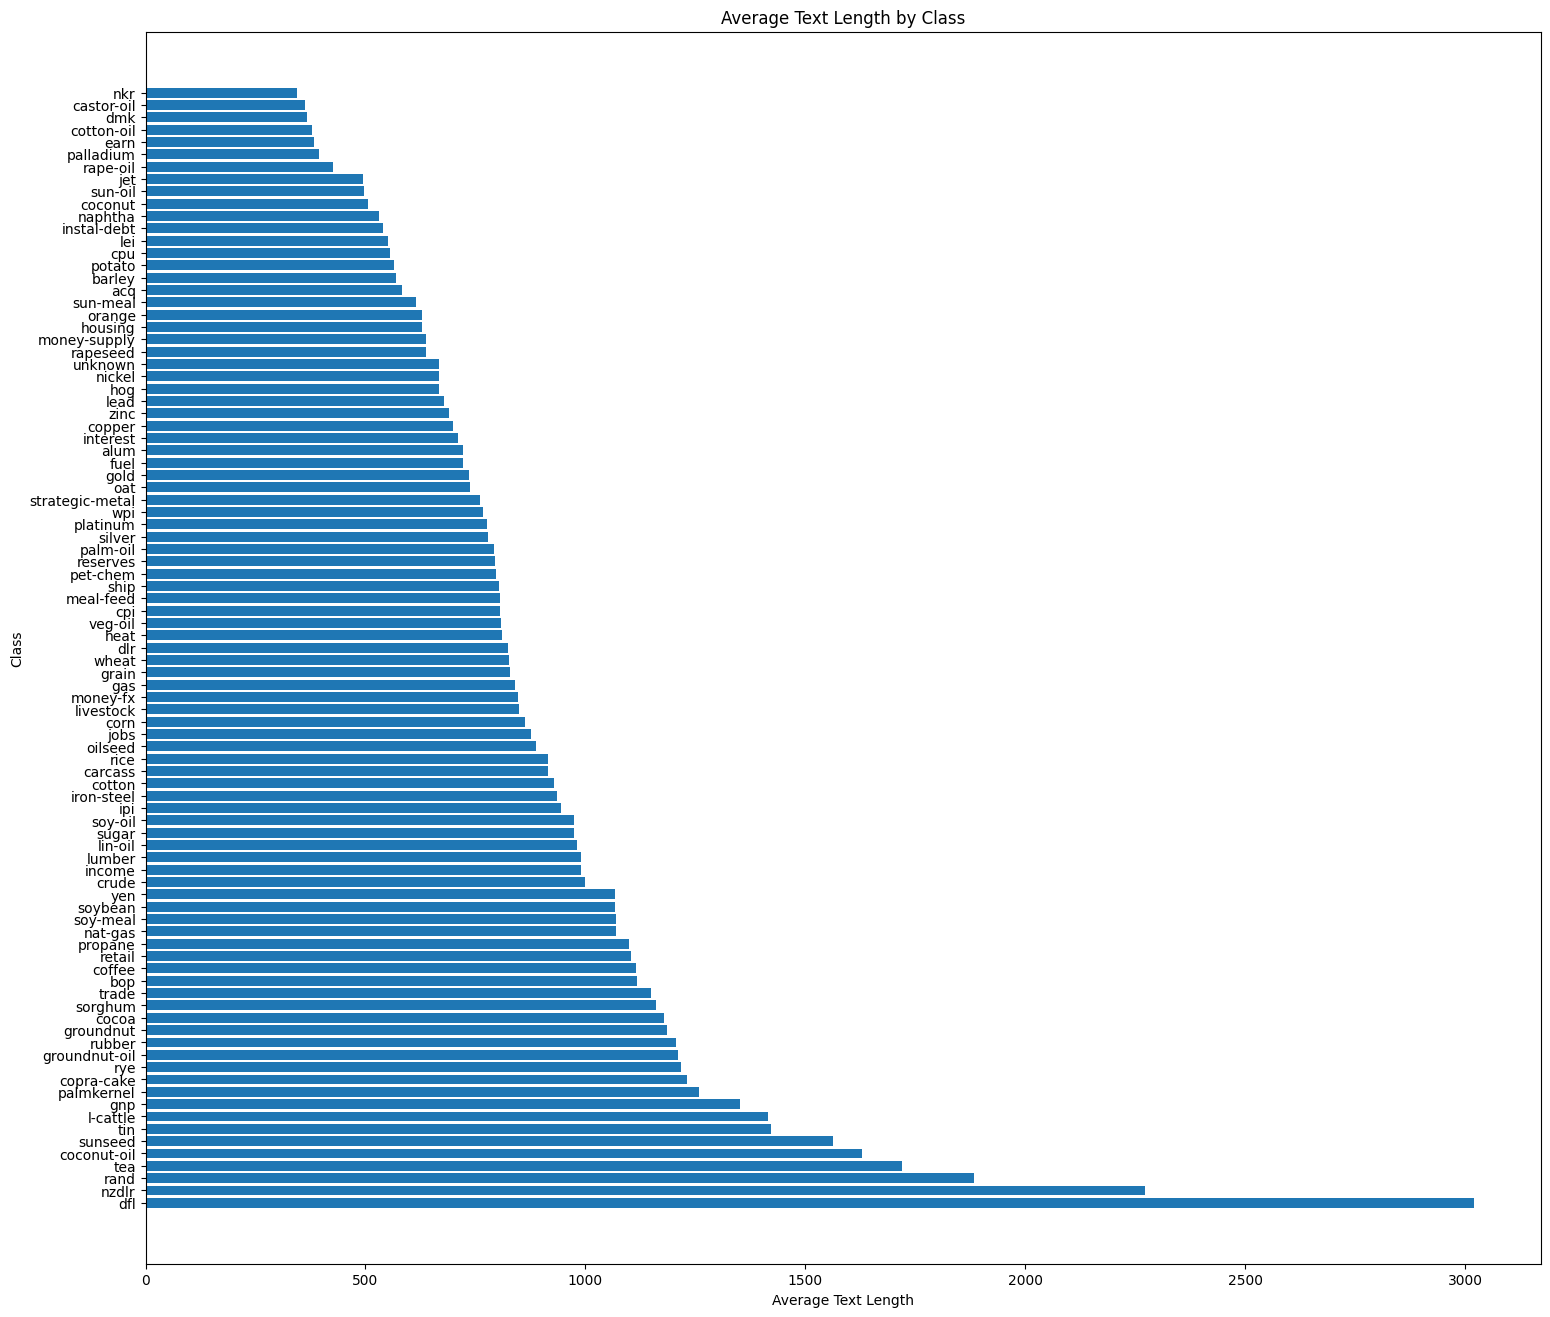

In [14]:
avg_text_length_by_class = data.groupby('folder_name')['text_length'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(18, 16))
ax.barh(avg_text_length_by_class.index, avg_text_length_by_class.values)
ax.set_xlabel('Average Text Length')
ax.set_ylabel('Class')
ax.set_title('Average Text Length by Class')
plt.show()

After this step: I'll use the text length as a feature.  <br>
Although the values are too close, but the length of the text gives indication of its class.<br>
for example the top 3 longest classes are related to finiance and commerce, which are usually finincial reports. 

### Most Common words in each class and its frequency 

In [15]:
def most_frequent_word(text):
    """
    Given a text, return the most common word and its frequency.
    """
    words = str(text).split()
    word_counts = Counter(words)
    most_common_word, frequency = word_counts.most_common(1)[0]
    return most_common_word, frequency

def find_most_common_word(data):
    """
    Given a DataFrame with a 'text' column and a 'folder_name' column,
    group the data by folder name and find the most frequent word and its frequency
    in each group. Returns a new DataFrame with the results.
    """
    # Apply the most_frequent_word function to each group of the DataFrame
    most_common_words = data.groupby('folder_name')['text'].apply(most_frequent_word).apply(pd.Series)
    most_common_words.columns = ['most_common_word', 'frequency']

    # Reset the index to convert the 'folder_name' group into a column
    most_common_words = most_common_words.reset_index()

    return most_common_words

In [16]:
most_common_words = find_most_common_word(data)

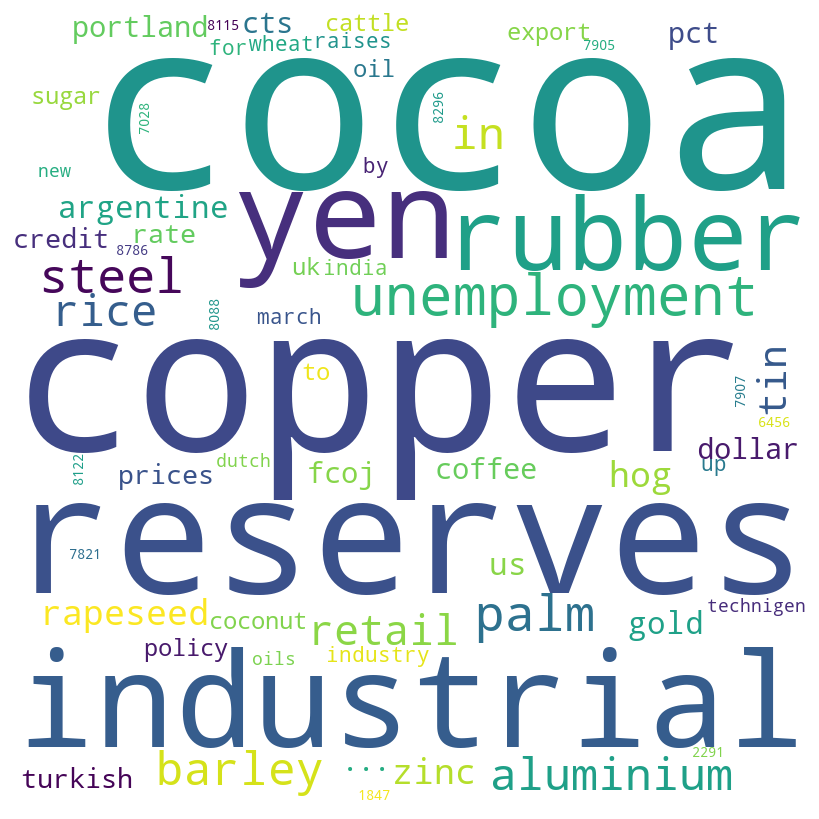

In [17]:
# Convert the dataframe to a dictionary
word_freq_dict = dict(zip(most_common_words['most_common_word'], most_common_words['frequency']))

# Create a WordCloud object with desired settings
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(word_freq_dict)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
# Show the plot
plt.show()  


In [18]:
most_frequent = most_common_words[most_common_words["frequency"]>5]
most_frequent[most_frequent["folder_name"] == most_frequent["most_common_word"]]

,folder_name,most_common_word,frequency
2,barley,barley,16
6,cocoa,cocoa,44
9,coffee,coffee,6
10,copper,copper,31
25,gold,gold,7
30,hog,hog,9
65,rapeseed,rapeseed,9
66,reserves,reserves,29
67,retail,retail,13
68,rice,rice,14


In [19]:
# most 10 common words
most_common_terms = most_common_words.sort_values('frequency', ascending=False).head(10)['most_common_word'].tolist()
print(most_common_terms)


['cocoa', 'copper', 'reserves', 'yen', 'industrial', 'rubber', 'unemployment', 'palm', 'steel', 'barley']


In [20]:
folder_names = set(data['folder_name'].unique())
non_class_freq_term = []

for term in most_common_terms:
    if term not in folder_names:
        non_class_freq_term.append(term)
non_class_freq_term

['industrial', 'unemployment', 'palm', 'steel']

From this substep we conclude that:
1. We have different types of documents: <br> 
    Some of the related to Checmical elements, Plants, Countires, and Finance. <br> 
    There are also lots of numbers that we need to study their source <br>
2. Many common words are the same as the class names: <br>
    We'll consider this point as a feature. 
3. There are some terms that are so frequent even tho they're not class names:<br>
    They're in the non_class_freq_term. I'll add them as features. 

### Topic Related terms 
Study the frequencies of terms related to these categories: Countries, Plants, Checmical Elements, Finance and Computer. 

In [21]:
# Define the categories and the corresponding keywords
CATEGORIES = {
    'Countries': ['country', 'nation', 'state', 'capital', 'city', 'language','United States', 'China', 'India', 'Russia', 'Brazil'],
    'Plants': ['plant', 'tree', 'flower', 'fruit', 'oil', 'vegetable', 'leaf', 'Rose', 'Orchid', 'Oak', 'Tomato', 'Potato'],
    'Chemical Elements': ['element', 'atom', 'compound', 'molecule', 'reaction', 'aluminium', 'bond', 'steel','Oxygen', 'Carbon', 'Hydrogen', 'Iron', 'Gold'],
    'Finance': ['financial', 'investment', 'market', 'money', 'stock', 'trade', 'Bitcoin', 'Tesla', 'Apple', 'Amazon', 'JP Morgan'],
    'Computer': ['computer', 'software', 'hardware', 'network', 'internet', 'programming', 'Microsoft', 'Google', 'Apple', 'Facebook', 'Amazon', 'Python', 'C++', 'Java', 'HTML', 'CSS', 'JavaScript'],
    'RandomFrequent': ['industrial', 'unemployment']
}


In [22]:
# Define a function to count the frequency of keywords for each category
def count_keywords(text, keywords):
    count = 0
    for word in keywords:
        escaped_word = re.escape(word)
        count += len(re.findall(rf"\b{escaped_word}\b", text.lower()))
    return count

In [23]:
# Add columns for the frequency of keywords for each category
for category in CATEGORIES:
    data[category] = data['text'].apply(lambda x: count_keywords(x, CATEGORIES[category]))

mean_freq = []
# Calculate the summary statistics for each category
for category in CATEGORIES:
    print(f"Category: {category}")
    print(f"Total number of keywords: {data[category].sum()}")
    print(f"Mean frequency of keywords: {data[category].mean()}")
    mean_freq.append(data[category].mean())
    print()


Category: Countries
Total number of keywords: 5270
Mean frequency of keywords: 0.4617541400157715

Category: Plants
Total number of keywords: 4808
Mean frequency of keywords: 0.4212739858056602

Category: Chemical Elements
Total number of keywords: 2249
Mean frequency of keywords: 0.19705598878471917

Category: Finance
Total number of keywords: 15079
Mean frequency of keywords: 1.3212126522386751

Category: Computer
Total number of keywords: 408
Mean frequency of keywords: 0.03574870761412424

Category: RandomFrequent
Total number of keywords: 787
Mean frequency of keywords: 0.06895645316744063



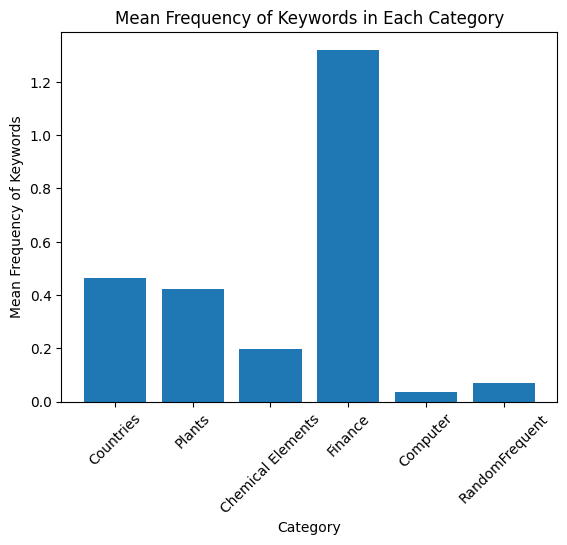

In [24]:
# Plot the mean frequency of keywords for each category
plt.bar(CATEGORIES.keys(), mean_freq)
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Mean Frequency of Keywords')
plt.title('Mean Frequency of Keywords in Each Category')
plt.show()

From the plot we conculde that most documents are related to Finance or talks about Countries. <br>
I'll add all of the topics as features. 

### Average Frequency of numbers in each Class. 

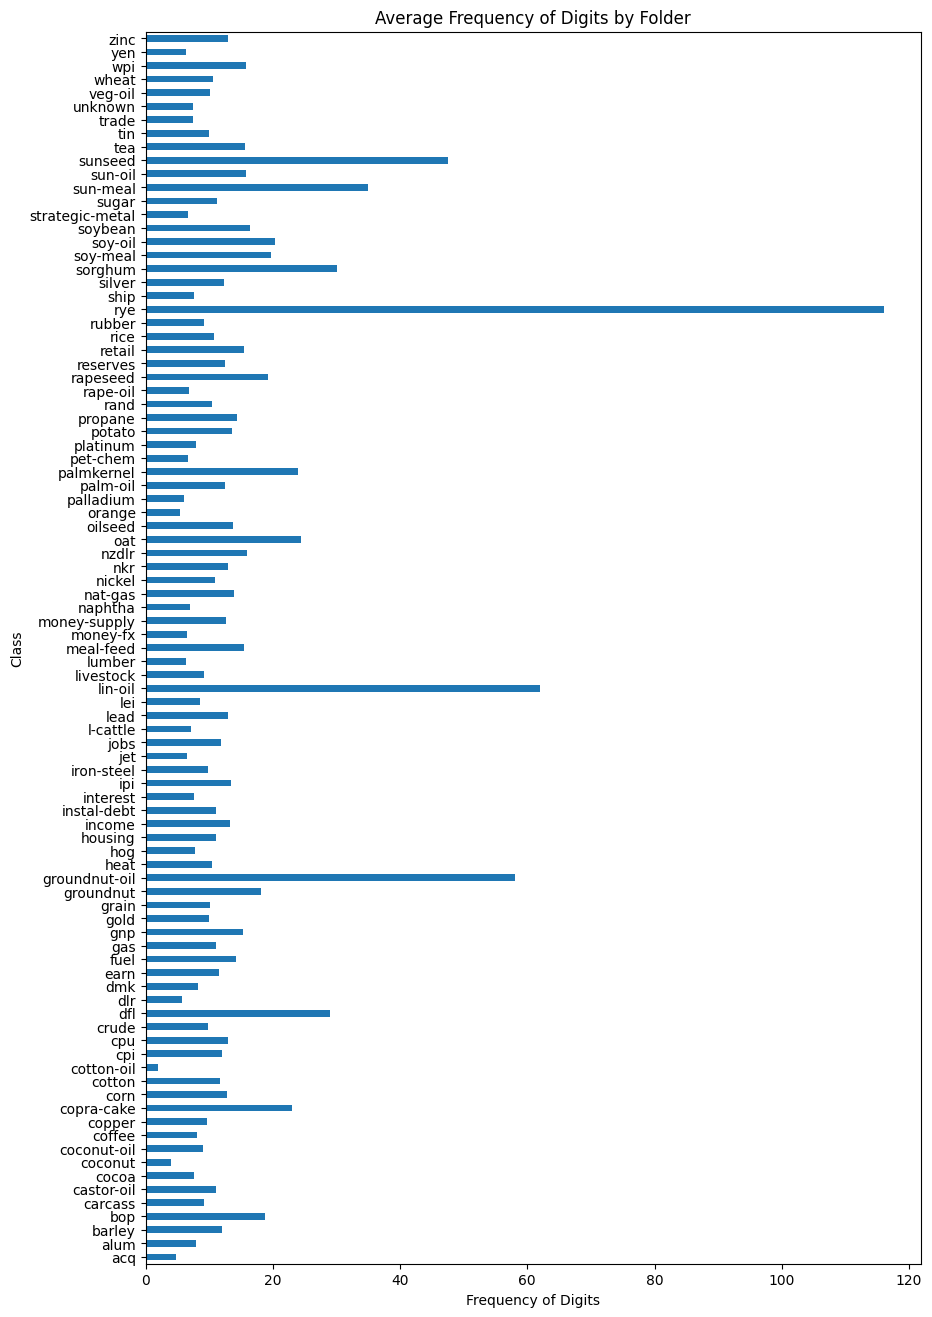

In [25]:
number_pattern = r'\d+(\.\d+)?'

def count_numbers(text):
    return len(re.findall(number_pattern, text))

# Group the data by folder_name and calculate the mean frequency of numbers for each group
freq_by_folder = data.groupby('folder_name')['text'].apply(lambda x: x.apply(count_numbers).mean())

# Plot the results in a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 16))
freq_by_folder.plot(kind='barh', ax=ax)
ax.set_title('Average Frequency of Digits by Folder')
ax.set_xlabel('Frequency of Digits')
ax.set_ylabel('Class')
plt.show()


The number of digits differ from classes, so it will be a good feature to consider.

## 6. Features Generation and Selection
The features I will add are:
- Document Length. 
- Prescence of class name in the document. 
- Prescence of topic related words, such as: Plant, Country, Finiance, Chemical Element, Computer and other manually selected terms. 
- Frequency of digits in the document. 

In [26]:
# Add document length as a feature
# data['doc_length'] = data['text_length']

# Add frequency of digits as a feature
data['digit_freq'] = data['text'].apply(count_numbers) 

# Add frequency of terms from each category as features
for category in CATEGORIES:
    data[f"{category}_freq"] = data[category]

# Add presence of class name in a document as a feature
class_names = set(data['folder_name'].unique())

for class_name in class_names:
    data[class_name] = data['text'].apply(lambda x: int(class_name in x.lower()))

feature_cols = ['doc_length' , 'digit_freq'] + [f"{category}_freq" for category in CATEGORIES] + list(class_names)

C:\Users\User\AppData\Local\Temp\ipykernel_6360\3427590900.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[class_name] = data['text'].apply(lambda x: int(class_name in x.lower()))


In [27]:
data.columns

Index(['folder_name', 'file_contents', 'text', 'tokens', 'text_length',
       'Countries', 'Plants', 'Chemical Elements', 'Finance', 'Computer',
       ...
       'crude', 'dlr', 'ship', 'soy-meal', 'groundnut-oil', 'propane', 'cpi',
       'unknown', 'grain', 'sunseed'],
      dtype='object', length=109)

In [28]:
data = data.rename(columns={'folder_name': 'Class'})
data.drop(columns=["file_contents", "tokens"], inplace=True)

In [44]:
# Convert the sparse matrix to a dense matrix
tfidf_dense = tfidf_vectors.toarray()

# Concatenate the dense matrix with the new features
X = np.concatenate([tfidf_dense, data[['text_length', 'digit_freq'] + [f"{category}_freq" for category in CATEGORIES] + list(class_names)]], axis=1)

print(X)
print(X.shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(11413, 11410)


## Machine Learning Algorithms
I have used three machine learning algorithms, which are: Random Forest, AdaBoost, and Logistic Regression. <br>
* <b>Random Forest </b> is an ensemble learning method that combines multiple decision trees to improve the overall performance of the model. It works by building a large number of decision trees on random subsets of the training data and then averaging their predictions to obtain the final output. This approach helps to reduce overfitting and improve the accuracy of the model.
<br>
* <b> AdaBoost </b> is also an ensemble learning method that combines multiple weak classifiers to build a strong classifier. It works by assigning weights to each data point and iteratively training weak classifiers on the data with higher weights. In each iteration, the weights of the misclassified data points are increased to give more emphasis on these points in the next iteration. The final output is obtained by combining the predictions of all weak classifiers, weighted by their accuracy.
<br>
* <b>Logistic Regression </b> It works by using a mathematical function called the logistic function to transform input data into a probability score between 0 and 1, which can then be used to make predictions. The logistic regression model estimates the relationship between the input variables and the outcome variable, and then uses this relationship to predict the probability of a positive outcome.

## 7. Training Models
In this step I'll train models on 85% of the data and test on the remaining 15%. <br>
The models I'll train on are:<br>
- Random Forest. 
- AdaBoost.
- Logistic Regression.

### Splitting the data to 85% training and 15% testing. 

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data['Class'], test_size=0.15, random_state=42)

### Train Random Forest 
Hyperparameters:
* n_estimators = 100: the number of trees in the forest
* max_depth = 50: the maximum depth of the trees
* random_state = 42: for reproducibility of results

In [46]:
# Train a Random Forest model on 85% of the data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [47]:
# Save the trained model to a file
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

### Evaluate Random Forest

In [57]:
# Make predictions on the test set
rf_pred = rf_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, rf_pred, zero_division=1))

              precision    recall  f1-score   support

         acq       0.56      0.54      0.55       261
        alum       1.00      0.00      0.00         5
      barley       0.00      0.00      0.00         8
         bop       1.00      0.00      0.00        10
     carcass       1.00      0.00      0.00         5
       cocoa       0.69      0.69      0.69        13
     coconut       1.00      0.00      0.00         1
      coffee       0.69      0.65      0.67        17
      copper       0.50      0.17      0.25         6
        corn       0.21      0.09      0.13        32
      cotton       1.00      0.00      0.00         9
         cpi       1.00      0.00      0.00        12
       crude       0.46      0.49      0.48        63
         dlr       0.00      0.00      0.00        17
         dmk       1.00      0.00      0.00         1
        earn       0.50      0.86      0.63       404
        fuel       1.00      0.00      0.00         1
         gas       0.00    

The Random Forest model does not seem to perform well. The accuracy of 0.40 suggests that the model only correctly classified 40% of the documents in the test set <br>

The macro average F1-score of 0.10 suggests that the model is not performing well in terms of precision and recall, while the weighted average F1-score of 0.34 suggests that the model has lower performance on the under-represented classes.

### Train AdaBoost

In [49]:
# Train an AdaBoost model on 85% of the data
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)


AdaBoostClassifier(n_estimators=100, random_state=42)

In [50]:
# Save the trained model to a file
with open('ada_model.pkl', 'wb') as file:
    pickle.dump(ada_model, file)

### Evaluate AdaBoost

In [58]:
# Make predictions on the test set
ada_pred = ada_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, ada_pred, zero_division=1))


              precision    recall  f1-score   support

         acq       0.69      0.44      0.54       261
        alum       1.00      0.00      0.00         5
      barley       1.00      0.00      0.00         8
         bop       1.00      0.00      0.00        10
     carcass       1.00      0.00      0.00         5
       cocoa       1.00      0.00      0.00        13
     coconut       1.00      0.00      0.00         1
      coffee       1.00      0.00      0.00        17
      copper       1.00      0.00      0.00         6
        corn       1.00      0.00      0.00        32
      cotton       1.00      0.00      0.00         9
         cpi       1.00      0.00      0.00        12
       crude       1.00      0.00      0.00        63
         dlr       1.00      0.00      0.00        17
         dmk       1.00      0.00      0.00         1
        earn       0.25      0.95      0.39       404
        fuel       1.00      0.00      0.00         1
         gas       1.00    

the AdaBoost model has an accuracy of 0.29, meaning that it correctly classified 29% of the documents. <br> The precision score of 0.78 indicates that when the model predicts a document as belonging to a certain class, it is correct 78% of the time. <br> The recall score of 0.29 indicates that the model correctly identifies only 29% of the documents that actually belong to a certain class.<br> The F1-score of 0.18 is low, suggesting that the model is not performing well in terms of both precision and recall.<br> The macro average F1-score of 0.01 suggests that the model is not performing well in terms of precision and recall.

### Train Logistic Regression

In [55]:
# Train a logistic regression model on the training data
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

c:\Users\User\textClassinNLP\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [67]:
# Save the trained model to a file
with open('lr.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

### Evaluate Logistic Regression

In [68]:
# Evaluate the model on the testing data
lr_pred = lr_model.predict(X_test)

# Print the classification report 
print(classification_report(y_test, lr_pred, zero_division=1))

              precision    recall  f1-score   support

         acq       0.21      0.20      0.21       261
        alum       1.00      0.00      0.00         5
      barley       1.00      0.00      0.00         8
         bop       1.00      0.00      0.00        10
     carcass       1.00      0.00      0.00         5
       cocoa       1.00      0.00      0.00        13
     coconut       1.00      0.00      0.00         1
      coffee       1.00      0.00      0.00        17
      copper       1.00      0.00      0.00         6
        corn       1.00      0.00      0.00        32
      cotton       1.00      0.00      0.00         9
         cpi       1.00      0.00      0.00        12
       crude       1.00      0.00      0.00        63
         dlr       1.00      0.00      0.00        17
         dmk       1.00      0.00      0.00         1
        earn       0.42      0.84      0.56       404
        fuel       1.00      0.00      0.00         1
         gas       1.00    

Based on the evaluation results for the logistic regression model, we can see that the model is not performing well. The accuracy score of 0.31 suggests that the model is only predicting the correct class about a third of the time.
<br>
Looking at the macro average F1-score of 0.01, we can see that the model is not performing well in terms of precision and recall for all classes. Additionally, the weighted average F1-score of 0.21 suggests that the model is performing poorly on the under-represented classes.

## Model Evaluation


### Compare Results of the Three models

In [62]:
# Compute accuracy for each model
rf_acc = accuracy_score(y_test, rf_pred)
ada_acc = accuracy_score(y_test, ada_pred)
lr_acc = accuracy_score(y_test, lr_pred)

# Compute precision, recall, and F1-score for each model
rf_p, rf_r, rf_f1, _ = precision_recall_fscore_support(y_test, rf_pred, average='weighted', zero_division=1)
ada_p, ada_r, ada_f1, _ = precision_recall_fscore_support(y_test, ada_pred, average='weighted', zero_division=1)
lr_p, lr_r, lr_f1, _ = precision_recall_fscore_support(y_test, lr_pred, average='weighted', zero_division=1)

# Print the results
print("Random Forest: Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(rf_acc, rf_p, rf_r, rf_f1))
print("AdaBoost: Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(ada_acc, ada_p, ada_r, ada_f1))
print("Logistic Regression: Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(lr_acc, lr_p, lr_r, lr_f1))

# Compute evaluation metrics for each model
rf_metrics = [rf_acc, rf_p, rf_r, rf_f1]
ada_metrics = [ada_acc, ada_p, ada_r, ada_f1]
lr_metrics = [lr_acc, lr_p, lr_r, lr_f1]


Random Forest: Accuracy = 0.456, Precision = 0.450, Recall = 0.456, F1-score = 0.393
AdaBoost: Accuracy = 0.292, Precision = 0.776, Recall = 0.292, F1-score = 0.175
Logistic Regression: Accuracy = 0.307, Precision = 0.610, Recall = 0.307, F1-score = 0.211


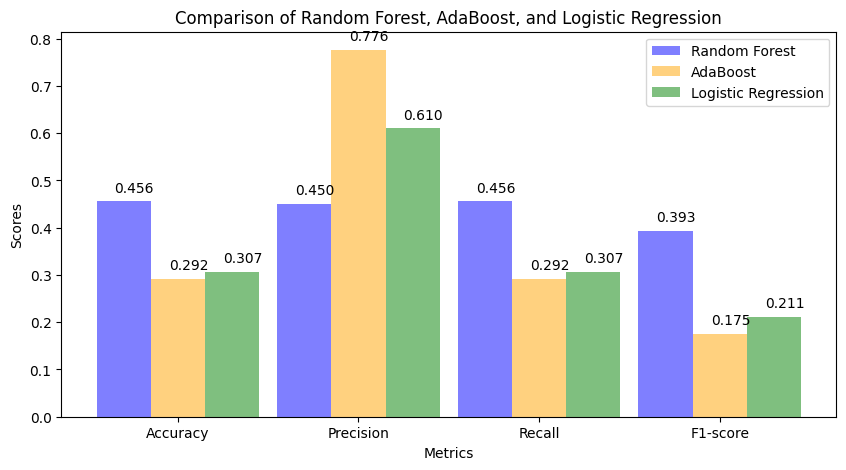

In [66]:
# Define the data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Set the positions and width of the bars
pos = list(range(len(metrics)))
width = 0.3

# Create the figure and set the plot dimensions
fig, ax = plt.subplots(figsize=(10,5))

# Create the bars for each model
plt.bar([p - width for p in pos], rf_metrics, width, alpha=0.5, color='blue', label='Random Forest')
plt.bar(pos, ada_metrics, width, alpha=0.5, color='orange', label='AdaBoost')
plt.bar([p + width for p in pos], lr_metrics, width, alpha=0.5, color='green', label='Logistic Regression')

# Set the plot title, labels, and legend
ax.set_title('Comparison of Random Forest, AdaBoost, and Logistic Regression')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_xticks(pos)
ax.set_xticklabels(metrics)
plt.legend(loc='upper right')

# Add text labels to each bar
for i, val in enumerate(rf_metrics):
    ax.text(i-width-0.05, val+0.02, "{:.3f}".format(val))
for i, val in enumerate(ada_metrics):
    ax.text(i-0.05, val+0.02, "{:.3f}".format(val))
for i, val in enumerate(lr_metrics):
    ax.text(i+width-0.05, val+0.02, "{:.3f}".format(val))

# Display the plot
plt.show()


We can see that the Random Forest model has the highest accuracy score at 0.456, but its precision, recall, and F1-score are relatively low. On the other hand, the AdaBoost model has a high precision score at 0.776 but its recall, F1-score, and accuracy are low. The Logistic Regression model has the lowest accuracy score at 0.307 and its precision, recall, and F1-score are also relatively low. Overall, it appears that none of the models perform particularly well, and further improvements are likely necessary.

## Model Enhancement

There are several ways we can enhance the models such as
1. In Text Preprocessing & EDA: use meaningful HTML tags and extract relevant information such as dates or prices. 
2. In Text Vectorization: use alternative methods to tf-idf such as word2vec, to capture the meaning of the text better. 
3. In Modelling: use Ensembling technoques such as bagging or boosting. 
4. In splitting data: use cross validation and perform hyperparameter tuning. 
By implementing these strategies, we can potentially improve the accuracy and overall performance of our models.